# DATA 410 Lecture 7 - Spring 2021

<font face="Chalkboard" color="darkgreen" size=5> Validated Comparisons with Different Methods</font>

In [2]:
# general imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [3]:
# Tricubic Kernel
def tricubic(x):
  return np.where(np.abs(x)>1,0,70/81*(1-np.abs(x)**3)**3)

# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2)) 

# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2)

In [4]:
#Defining the kernel local regression model

def lowess_kern(x, y, kern, tau):

    # tau is called bandwidth K((x-x[i])/(2*tau))

    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the kernel function by using only the train data    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

def model_lowess(dat_train,dat_test,kern,tau):
  dat_train = dat_train[np.argsort(dat_train[:, 0])]
  dat_test = dat_test[np.argsort(dat_test[:, 0])]
  Yhat_lowess = lowess_kern(dat_train[:,0],dat_train[:,1],kern,tau)
  datl = np.concatenate([dat_train[:,0].reshape(-1,1),Yhat_lowess.reshape(-1,1)], axis=1)
  f = interp1d(datl[:,0], datl[:,1],fill_value='extrapolate')
  return f(dat_test[:,0])

In [5]:
# imports for creating a Neural Networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [6]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Boston Housing Prices.csv')

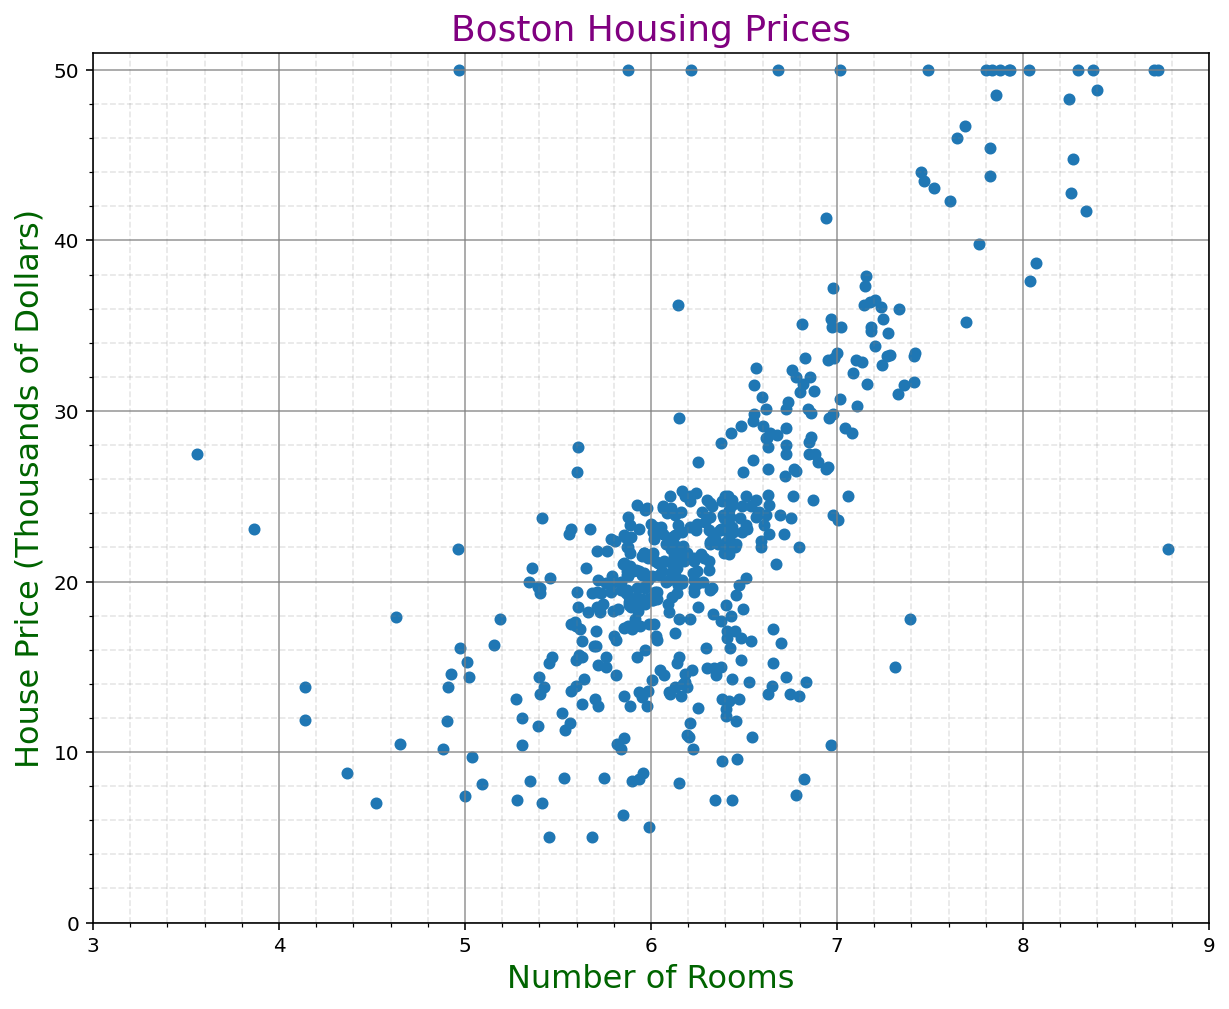

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=df['rooms'], y=df['cmedv'],s=25)
ax.set_xlabel('Number of Rooms',fontsize=16,color='darkgreen')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='darkgreen')
ax.set_title('Boston Housing Prices',fontsize=18,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.show()

In [8]:
X = np.array(df['rooms']).reshape(-1,1)
y = np.array(df['cmedv']).reshape(-1,1)
dat = np.concatenate([X,y.reshape(-1,1)], axis=1)

In [9]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=2021)

y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

dat_train = np.concatenate([X_train,y_train.reshape(-1,1)], axis=1)
dat_train = dat_train[np.argsort(dat_train[:, 0])]

dat_test = np.concatenate([X_test,y_test.reshape(-1,1)], axis=1)
dat_test = dat_test[np.argsort(dat_test[:, 0])]

In [ ]:
# Create a Neural Network model
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=1))
model.add(Dense(32, activation="relu"))
model.add(Dense(8, activation="relu"))
# Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
# Typically ReLu-based activation are used but since it is performed regression, it is needed a linear activation.
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=100, verbose=1, callbacks=[es])

# Calculate predictions
yhat_nn = model.predict(dat_test[:,0])

## Here are the predictions we made for the test data:

In [ ]:
yhat_nn

In [13]:
from sklearn.metrics import mean_absolute_error

yhat_nn = model.predict(dat_test[:,0])
mae_nn = mean_absolute_error(dat_test[:,1], yhat_nn)
print("MAE Neural Network = ${:,.2f}".format(1000*mae_nn))

MAE Neural Network = $3,827.33


In [14]:
yhat_lr = model_lowess(dat_train,dat_test,Quartic,0.45)
mae_nn = mean_absolute_error(dat_test[:,1], yhat_lr)
print("MAE Kernel Weighted Regression = ${:,.2f}".format(1000*mae_nn))

MAE Kernel Weighted Regression = $3,799.25


In [15]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

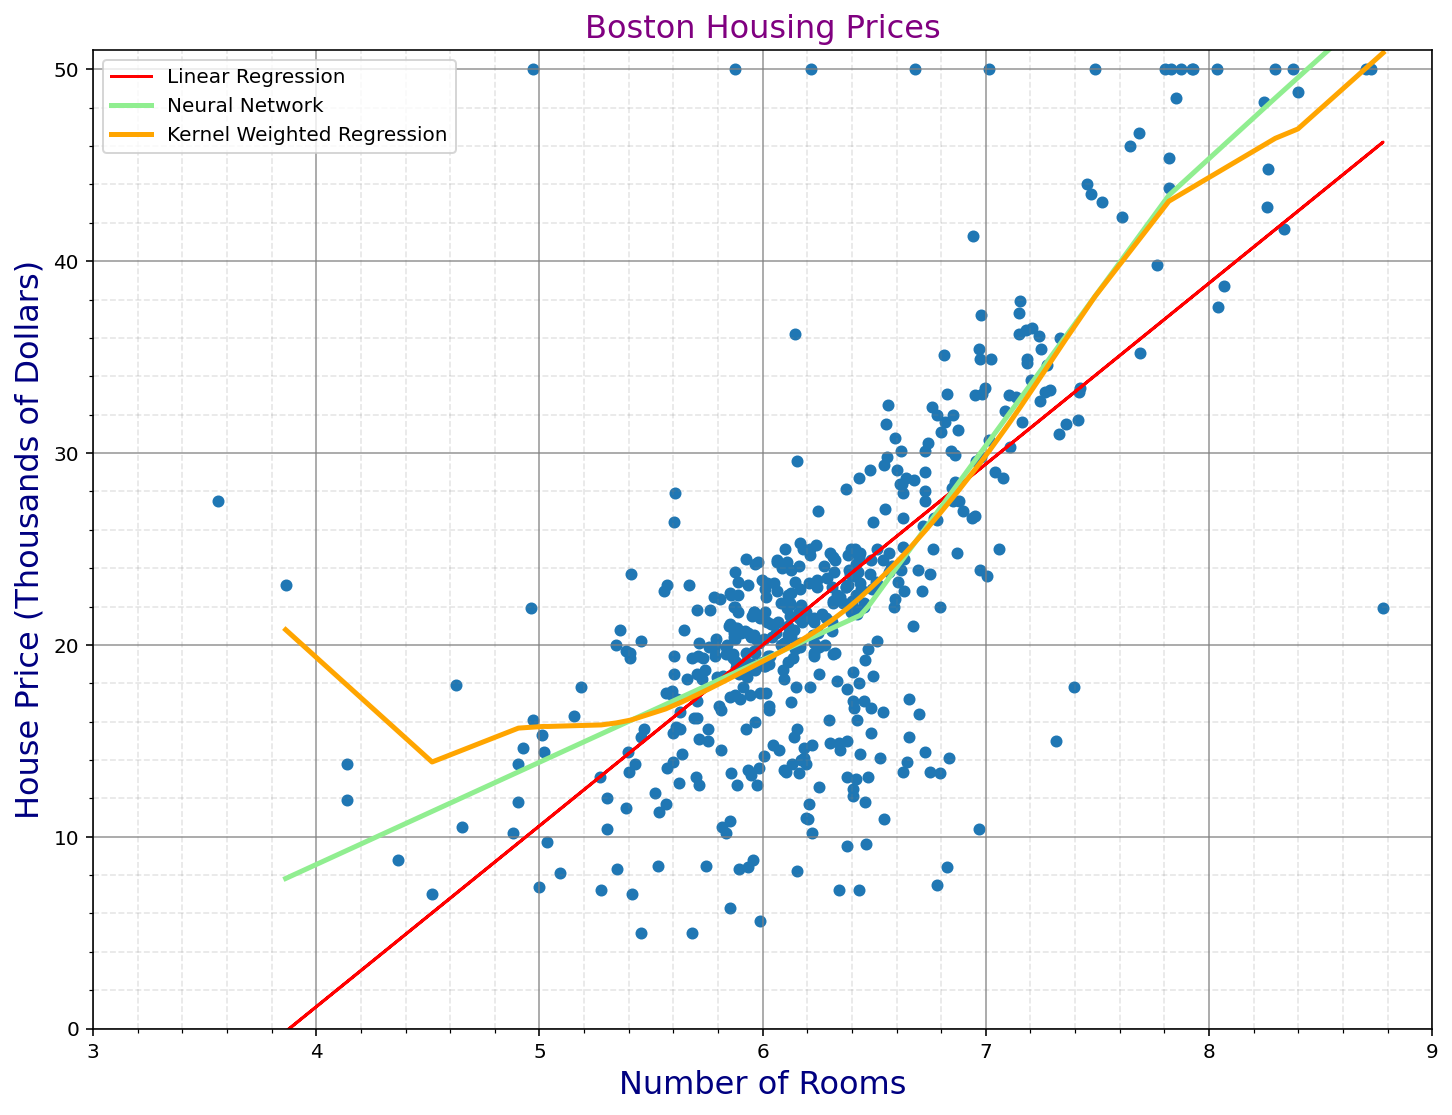

In [17]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_xlim(3, 9)
ax.set_ylim(0, 51)
ax.scatter(x=df['rooms'], y=df['cmedv'],s=25)
ax.plot(X_test, lm.predict(X_test), color='red',label='Linear Regression')
ax.plot(dat_test[:,0], yhat_nn, color='lightgreen',lw=2.5,label='Neural Network')
ax.plot(dat_test[:,0], model_lowess(dat_train,dat_test,Quartic,0.45), color='orange',lw=2.5,label='Kernel Weighted Regression')
ax.set_xlabel('Number of Rooms',fontsize=16,color='navy')
ax.set_ylabel('House Price (Thousands of Dollars)',fontsize=16,color='navy')
ax.set_title('Boston Housing Prices',fontsize=16,color='purple')
ax.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.8)
ax.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.2)
ax.minorticks_on()
plt.legend()

In [18]:
from sklearn.model_selection import KFold

In [19]:
kf = KFold(n_splits=10, shuffle=True, random_state=2021)

In [21]:
mae_lm = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0]
  y_train = dat[idxtrain,1]
  X_test  = dat[idxtest,0]
  y_test = dat[idxtest,1]
  lm.fit(X_train.reshape(-1,1),y_train)
  yhat_lm = lm.predict(X_test.reshape(-1,1))
  mae_lm.append(mean_absolute_error(y_test, yhat_lm))
print("Validated MAE Linear Regression = ${:,.2f}".format(1000*np.mean(mae_lm)))

Validated MAE Linear Regression = $4,433.17


In [28]:
%%timeit -n 1

mae_lk = []

for idxtrain, idxtest in kf.split(dat):
  dat_test = dat[idxtest,:]
  y_test = dat_test[np.argsort(dat_test[:, 0]),1]
  yhat_lk = model_lowess(dat[idxtrain,:],dat[idxtest,:],Quartic,0.45)
  mae_lk.append(mean_absolute_error(y_test, yhat_lk))
print("Validated MAE Local Kernel Regression = ${:,.2f}".format(1000*np.mean(mae_lk)))

Validated MAE Local Kernel Regression = $4,107.47
Validated MAE Local Kernel Regression = $4,107.47
Validated MAE Local Kernel Regression = $4,107.47
1 loop, best of 3: 413 ms per loop


In [29]:
%%timeit -n 1

mae_nn = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0]
  y_train = dat[idxtrain,1]
  X_test  = dat[idxtest,0]
  y_test = dat[idxtest,1]
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
  model.fit(X_train.reshape(-1,1),y_train,validation_split=0.3, epochs=1000, batch_size=100, verbose=0, callbacks=[es])
  yhat_nn = model.predict(X_test.reshape(-1,1))
  mae_nn.append(mean_absolute_error(y_test, yhat_nn))
print("Validated MAE Neural Network Regression = ${:,.2f}".format(1000*np.mean(mae_nn)))

Epoch 00206: early stopping
Epoch 00221: early stopping
Epoch 00379: early stopping
Epoch 00283: early stopping
Epoch 00474: early stopping
Epoch 00299: early stopping
Epoch 00606: early stopping
Epoch 00551: early stopping
Epoch 00242: early stopping
Epoch 00570: early stopping
Validated MAE Neural Network Regression = $4,093.02
Epoch 00442: early stopping
Epoch 00355: early stopping
Epoch 00299: early stopping
Epoch 00397: early stopping
Epoch 00415: early stopping
Epoch 00217: early stopping
Epoch 00278: early stopping
Epoch 00300: early stopping
Epoch 00584: early stopping
Epoch 00484: early stopping
Validated MAE Neural Network Regression = $4,106.25
Epoch 00449: early stopping
Epoch 00924: early stopping
Epoch 00210: early stopping
Epoch 00216: early stopping
Epoch 00345: early stopping
Epoch 00203: early stopping
Epoch 00368: early stopping
Epoch 00476: early stopping
Epoch 00328: early stopping
Epoch 00332: early stopping
Validated MAE Neural Network Regression = $4,131.62
1 lo

## XGBoost

https://towardsdatascience.com/xgboost-python-example-42777d01001e

In [ ]:
import xgboost as xgb

In [ ]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=100,reg_lambda=20,alpha=1,gamma=10,max_depth=3)

In [ ]:
mae_xgb = []

for idxtrain, idxtest in kf.split(dat):
  X_train = dat[idxtrain,0]
  y_train = dat[idxtrain,1]
  X_test  = dat[idxtest,0]
  y_test = dat[idxtest,1]
  model_xgb.fit(X_train.reshape(-1,1),y_train)
  yhat_xgb = model_xgb.predict(X_test.reshape(-1,1))
  mae_xgb.append(mean_absolute_error(y_test, yhat_xgb))
print("Validated MAE XGBoost Regression = ${:,.2f}".format(1000*np.mean(mae_xgb)))

Validated MAE XGBoost Regression = $4,136.63
